In [1]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [2]:
def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap='gray')
        plt.title(window_name)
        plt.show()  

    

In [3]:
def normalized_cross_correlation(im_1, im_2):
    """
    Computes the normalized cross correlation between two images.
    """
    im_1_mean = np.mean(im_1)
    im_2_mean = np.mean(im_2)

    norm = np.sqrt(
                np.sum(np.power(im_2 - im_2_mean, 2))
                * np.sum(np.power(im_1 - im_2_mean, 2))
            )

    return np.sum(np.multiply(im_2 - im_2_mean, im_1 - im_1_mean)) / norm
    

In [4]:
def templ_matching_nxc(image, template):
    """
    Computes the normalized cross correlation between the template and every possible location in the image.
    :param image: image to search in
    :param template: template to search for
    :return: image with the normalized cross correlation
    """
    image_h, image_w = image.shape
    template_h, template_w = template.shape

    result = np.zeros(
        (image_h - template_h + 1, image_w - template_w + 1), dtype=np.float32
    )
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j] = normalized_cross_correlation(
                image[i : i + template_h, j : j + template_w], template
            )
    if result.min() < 0:
        result = result - result.min()
    result /= result.max()
    return result

In [5]:
def draw_rectangle_at_detection(image, template_shape, detection_positions):
    detection_positions = zip(detection_positions[0], detection_positions[1])
    for detection_position in detection_positions:
        cv.rectangle(
            image,
            (detection_position[1], detection_position[0]),
            (detection_position[1] + template_shape[1], detection_position[0] + template_shape[0]),
            0
        )
    return image

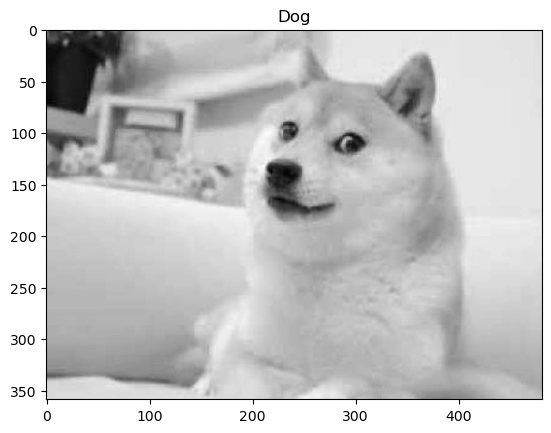

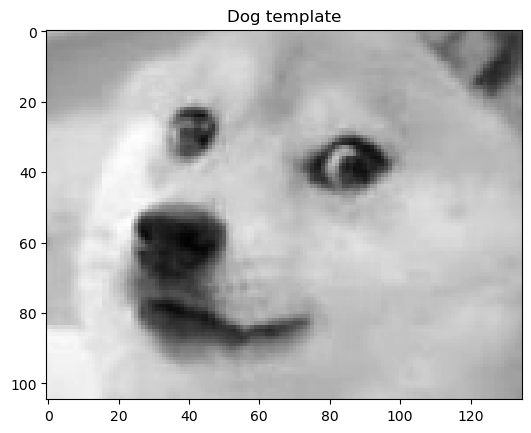

In [6]:
# set images pathes
dog_path = '../data/DogGray.jpeg'
dog_template_path = '../data/DogTemplate.jpeg'
# read imgs
dog = cv.imread(dog_path, cv.IMREAD_GRAYSCALE)
dog_template = cv.imread(dog_template_path, cv.IMREAD_GRAYSCALE)

display_image('Dog', dog)
display_image('Dog template', dog_template)

In [7]:
def build_gaussian_pyramid_opencv(image, num_levels):
    pyramid = [image]
    for i in range(num_levels - 1):
        pyramid.append(cv.pyrDown(pyramid[i])) 
    return pyramid

In [8]:

def template_matching_multiple_scales(pyramid_image, pyramid_template, visualize=False):
    """
    Performs template matching on multiple scales.
    :param pyramid_image: image pyramid
    :param pyramid_template: template pyramid
    :return: similarity map
    """

    # reverse pyramid_image and pyramid_template
    pyramid_image = pyramid_image[::-1]
    pyramid_template = pyramid_template[::-1]


    similarity_img = templ_matching_nxc(pyramid_image[0], pyramid_template[0])
    if similarity_img.min() < 0:
        similarity_img = similarity_img - similarity_img.min()
    similarity_img = similarity_img / similarity_img.max()

    if visualize:
        display_image(f'NXC-multiscale similarity image (level)', similarity_img)

    threshold = 0.67
    search_window_size = 7

    for i in range(1, len(pyramid_image)):
        detection_positions = np.where(similarity_img >= threshold)
        print(f"Number of detections in level {i-1}: {len(detection_positions[0])}")
        detection_positions = zip(detection_positions[0], detection_positions[1])

        similarity_img = np.zeros_like(pyramid_image[i])

        image_height, image_width = pyramid_image[i].shape
        template_height, template_width = pyramid_template[i].shape

        
        for detection_position in detection_positions:
            
            # upscale detection position for the next level
            detection_position = [detection_position[0] * 2, detection_position[1] * 2]
            #  detection_position = [x * 2 for x in detection_position]  # match location in the higher scale
            
            # check if the detection position is in the image, if not, set it to 0
            top_left_corner = max(detection_position[0] - search_window_size, 0), max(detection_position[1] - search_window_size, 0)
            detection_position[0] += template_height
            detection_position[1] += template_width

            # check if the detection position is in the image, if not, set it to heigth/width of image
            bottom_right_corner = min(detection_position[0] + search_window_size, image_height), min(detection_position[1] + search_window_size, image_width)

            patch = pyramid_image[i][
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ]

            #display_image(f'Patch', patch)

            # calculate similarity only inside of the patch
            similarity = templ_matching_nxc(patch, pyramid_template[i]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            similarity_result = np.zeros_like(patch)

            similarity_result[:similarity.shape[0], :similarity.shape[1]] = similarity #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # similarity_result = templ_matching_nxc(patch, pyramid_template[i])
            similarity_img_patch = similarity_img[
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ]
            #print(similarity_img_patch.max( ))
            # find location of increased similarity and save as mask
            mask = np.float32(similarity_result > similarity_img_patch)
            
            # increase values of similarty_img only where mask is 1 and only in the patch lacation
            similarity_img[
                top_left_corner[0] : bottom_right_corner[0],
                top_left_corner[1] : bottom_right_corner[1],
            ] = (mask * similarity_result + (1 - mask) * similarity_img_patch).astype(np.uint8)

        if visualize:
            display_image(f'NXC-multiscale similarity image (level{len(pyramid_image) - i})', similarity_img)
            
    return similarity_img


Number of detections in level 0: 6
Number of detections in level 1: 1
Number of detections in level 2: 1
Number of detections in level 3: 1
Time for NXC multiscale: 0.4910837999999984 seconds


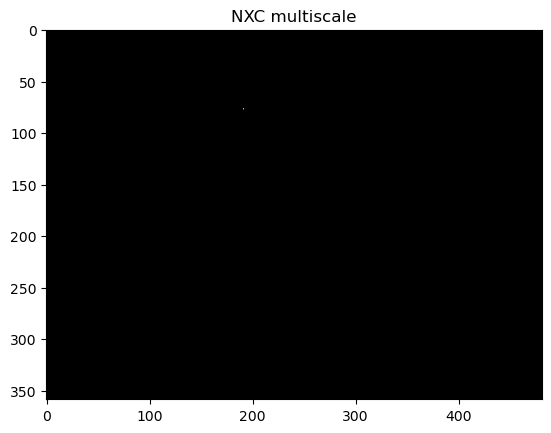

In [9]:
pyramid_cv = build_gaussian_pyramid_opencv(dog, 5)
pyramid_tmpl_cv = build_gaussian_pyramid_opencv(dog_template, 5)
start = time.perf_counter()
similarity_nxc_multiscale_img = template_matching_multiple_scales(pyramid_cv, pyramid_tmpl_cv)
end = time.perf_counter()
print(f"Time for NXC multiscale: {end - start} seconds")
display_image('NXC multiscale', similarity_nxc_multiscale_img)

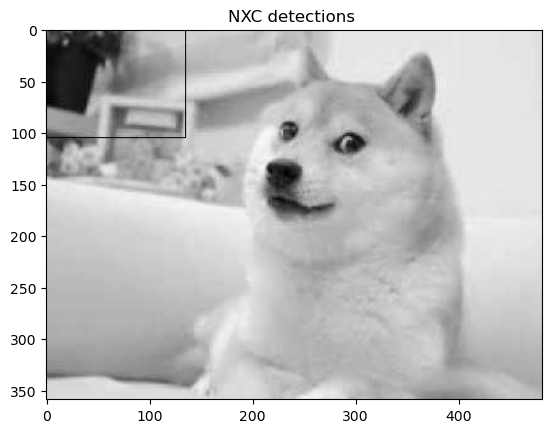

In [11]:

result_multiscale_ = draw_rectangle_at_detection(dog, pyramid_tmpl_cv[0].shape, similarity_nxc_multiscale_img)
display_image(f'NXC detections ', result_multiscale_)